# Learning and controlling a room's temperature
### Farzad Vatandoust/email: vatandoustf@gamil.com


$C\dot{T}  = K(T_a(t) - T(t))+\dot{m}_s(t) c_a (T_s(t)-T(t))+d(t)$

System output:
- $T(t)$: the room temperature at time $t$

Control parameters:
- $\dot{m}_s$: mass flow rate
- $T_s(t)$: temperature of the supply air

System parameters:
- $K$: the heat transfer coefficient
- $T_a$: the temperature outside the room at time $t$ (Constant)
- $c_a$: the specific heat capacity of air
- $d(t)$:the unknown disturbance into the room at time $t$ (Constant)
- $C$: the heat capacity of the room air,

## Section 1: Loading and analyzing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv')
values = dataset.values
# drop unwanted data
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                    time  room_temp  supply_temp  airflow_current
0  2021-04-26T09:37:00.0       72.3         59.3              416
1  2021-04-26T09:38:00.0       72.2         58.8              413
2  2021-04-26T09:39:00.0       72.2         58.5              419
3  2021-04-26T09:40:00.0       72.1         58.2              410
4  2021-04-26T09:41:00.0       71.9         58.1              404


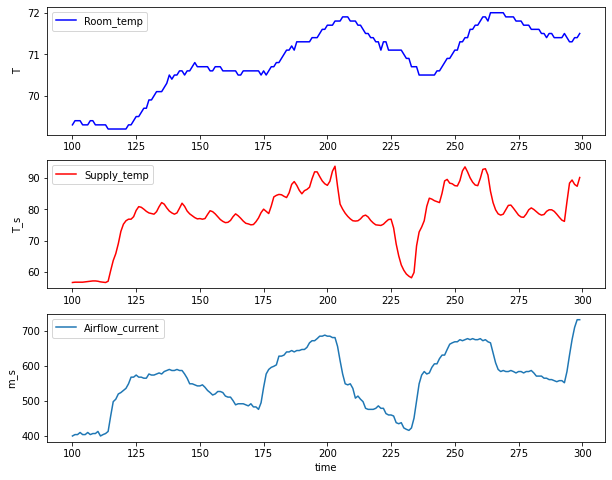

In [3]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

### Train/Test/Validation split (Global)
Useful link https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37

In [5]:
train_nu = int(np.floor(0.7 * len(dataset)))
test_nu = int(np.floor(0.15 * len(dataset)))
val_nu = len(dataset) - train_nu - test_nu

# Section 2: Learn a differential equation model


Load required libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize

Train/Test/Validation split

In [7]:
train_data = dataset[0:train_nu]
test_data = dataset[train_nu:train_nu + test_nu]
val_data= dataset[train_nu + test_nu: ]

## 2.1 Simulation diffeential equation
- gekko IPOPT : https://apmonitor.com/do/index.php/Main/TCLabA (Too Slow)
- scipy odeint : 
- solve_ivp : 

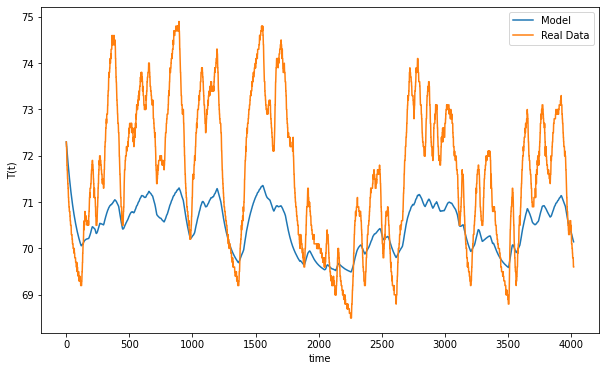

In [15]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = np.array([50, 68.94, 0.005, 50, 4000.35])
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

## 2.2 Optimization for parameter estimation



In [16]:
def objective_func(p):
    Ts = np.array(train_data['supply_temp'])
    Ms = np.array(train_data['airflow_current'])
    T0 = train_data['room_temp'][0]
    t = np.arange(0, train_nu, 1)
    T = np.zeros(train_nu)
    T[0] = T0
    z0 = T0
    for i in range (1, train_nu):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    real = np.array(train_data['room_temp'][:train_nu])
    predicted = T
    mse = sum((real-predicted)**2)/train_nu
    return mse
    

In [17]:
p = np.array([10, 10, 10, 10, 1000])
objective_func(p)

172.24577883870975

In [ ]:
bounds = [(0.0, 200), 
            (0.0, 200),
            (0.0, 200),
            (0, 200),
            (1000, 10000)]
Nfeval = 1
def callbackF(Xi, k1, k2):
    global Nfeval
    print ('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}  {5: 3.6f}  {6: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], Xi[3], Xi[4], objective_func(Xi)))
    Nfeval += 1
print('{0:4s}   {1:9s}   {2:9s}   {3:9s}   {4:9s}  {5:9s}   {6:9s}'.format('Iter', ' X1', ' X2', ' X3', ' X4', ' X5', 'f(X)'))
result = optimize.dual_annealing(objective_func, bounds, callback=callbackF)

In [439]:
objective_func(result.x)


0.0044177788087718705

## 2.3 Optimized Model

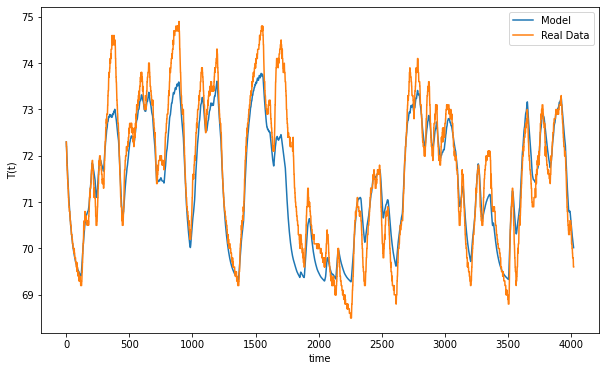

In [440]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt
    
p = result.x
Ts = np.array(train_data['supply_temp'])
Ms = np.array(train_data['airflow_current'])
T0 = train_data['room_temp'][0]
t = np.arange(0, train_nu, 1)
T = np.zeros(train_nu)
T[0] = T0
z0 = T0
for i in range (1, train_nu):
    ts = (t[i-1], t[i])
    # solve ODE
    z = solve_ivp(model, t_span=ts, y0=[z0],
                args=(p, Ts[i-1], Ms[i-1]))
    T[i] = z.y[0][-1]
    z0 = z.y[0][-1]

# plot results
fig = plt.figure(figsize=(10, 6))
plt.plot(t, T)
plt.plot(t, train_data['room_temp'][t])
plt.legend(["Model","Real Data"])
plt.xlabel('time')
plt.ylabel('T(t)')
plt.show()

# Section 2: Learn  a Neural Network Model

- Recurrent Neural Networks (RNN) by sentdex: https://www.youtube.com/watch?v=BSpXCRTOLJA&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=7
- Multivariate Time Series Forecasting with LSTMs in Keras: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- How to Convert a Time Series to a Supervised Learning Problem in Python: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [ ]:
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


: 

In [ ]:
# load dataset
dataset = read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

: 

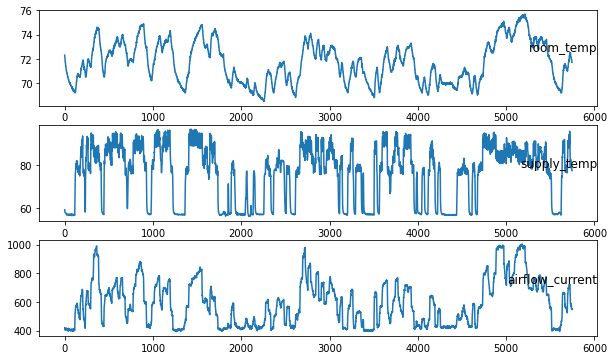

In [17]:
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure(figsize=(10, 6))
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

: 

In [19]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('maximum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
maximum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


In [20]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4022, 1, 3) (4022,) (862, 1, 3) (862,)


Epoch 1/100
32/32 - 3s - loss: 0.1631 - val_loss: 0.0264 - 3s/epoch - 92ms/step
Epoch 2/100
32/32 - 0s - loss: 0.0503 - val_loss: 0.0079 - 121ms/epoch - 4ms/step
Epoch 3/100
32/32 - 0s - loss: 0.0168 - val_loss: 0.0143 - 122ms/epoch - 4ms/step
Epoch 4/100
32/32 - 0s - loss: 0.0131 - val_loss: 0.0131 - 123ms/epoch - 4ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0124 - val_loss: 0.0117 - 127ms/epoch - 4ms/step
Epoch 6/100
32/32 - 0s - loss: 0.0117 - val_loss: 0.0108 - 120ms/epoch - 4ms/step
Epoch 7/100
32/32 - 0s - loss: 0.0110 - val_loss: 0.0098 - 125ms/epoch - 4ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0103 - val_loss: 0.0089 - 127ms/epoch - 4ms/step
Epoch 9/100
32/32 - 0s - loss: 0.0096 - val_loss: 0.0081 - 131ms/epoch - 4ms/step
Epoch 10/100
32/32 - 0s - loss: 0.0089 - val_loss: 0.0073 - 120ms/epoch - 4ms/step
Epoch 11/100
32/32 - 0s - loss: 0.0083 - val_loss: 0.0066 - 137ms/epoch - 4ms/step
Epoch 12/100
32/32 - 0s - loss: 0.0076 - val_loss: 0.0060 - 121ms/epoch - 4ms/step
Epoch 13/100
32

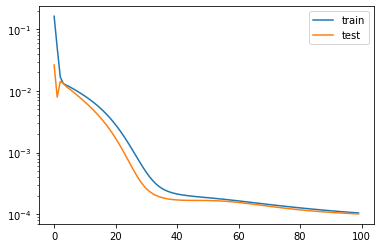

In [136]:
...
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

In [137]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.072


In [138]:
# Save the Model
model.save('LSTM_room_temp')

INFO:tensorflow:Assets written to: LSTM_room_temp\assets


INFO:tensorflow:Assets written to: LSTM_room_temp\assets


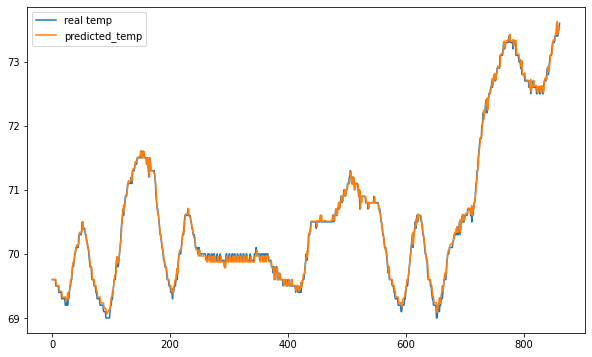

In [139]:
t = np.arange(0, len(inv_y))
pyplot.figure(figsize=(10, 6))
pyplot.plot(t, inv_y)
pyplot.plot(t, inv_yhat)
pyplot.legend(['real temp', 'predicted_temp'])
pyplot.show()

# Section 3: MPC control

- Model Predictive Control by Steve Brunton : https://www.youtube.com/watch?v=YwodGM2eoy4

- John Hedengren site: https://apmonitor.com/do/index.php/Main/TCLabG
- https://www.youtube.com/playlist?list=PLn8PRpmsu08ozoeoXgxPSBKLyd4YEHww8
- https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html
- https://github.com/gasagna/mpc
- https://yalmip.github.io/example/standardmpc/
- https://www.itk.ntnu.no/fag/TTK4135/Pensum/MPCkompendium%20HOvd.pdf

- https://www.youtube.com/watch?v=DFqOf5wbQtc

Important paper: Recurrent Neural Network-Based Model Predictive Control for Continuous Pharmaceutical Manufacturing https://www.mdpi.com/2227-7390/6/11/242/htm

- https://stackoverflow.com/questions/65720961/neural-network-mpc
- https://www.youtube.com/watch?v=uqivOJVbUNY
- https://www.youtube.com/watch?v=RrnkPrcpyEA

$Objective\:function = ||yt - y|| + c * \sum(a(T_s - 55) + b(\dot{m}_s-400) $

$ Subject\:to: 55<T_s<90,\: 400<\dot{m}_s<1000\:(Soft\:constraints)
$  

$ Subject\:to:|\Delta{T_s}|<8,\: |\Delta{\dot{m}_s}|<65\:(Hard\:constraints)$

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


: 

Load the model and weights of our LSTM

In [22]:
LSTM_model = keras.models.load_model("LSTM_room_temp")

In [25]:

def F_LSTM(T, Ts, Ms):
    input = np.array([T, Ts, Ms]).astype('float32').reshape(1,-1)

    scaled = scaler.transform(input)
    scaled_reframed = scaled.reshape((scaled.shape[0], 1, scaled.shape[1]))
    output = LSTM_model(scaled_reframed)
    inv_output = concatenate((output, scaled[:, 1:]), axis=1)
    inv_output = scaler.inverse_transform(inv_output)
    inv_output = inv_output[:,0]
    T_new = inv_output
    
    return T_new

In [ ]:
T = 70
Ts = 55
Ms = 400
F_LSTM(T, Ts, Ms)

: 

In [ ]:
def objective_fun(input, args):
    # args =(T_now, p, target_temp)
    T_now = args[0]
    p = args[1]
    target_temp = args[2]

    T_target = np.full((p,), target_temp)
    T = np.zeros(p)

    T[0] = F_LSTM(T_now, input[0], input[p])
    
    for i in range(1, p):
        T[i] = F_LSTM(T[i-1], input[i+0], input[i+p])

    cost1 = sum((T_target - T)**2)
    return cost1

MPC with Scipy optimization (ran into problem)

In [ ]:
def MPC(T_now, Ts_old, Ms_old, p, target_temp, Ts_min, Ms_min, Ts_max, Ms_max ):

    input = np.zeros(2*p)
    input[0:p] = Ts_min
    input[p:] = Ms_min
    
    bnds = []
    for i in range(p):
        bnds.append((Ts_min, Ts_max))

    for i in range(p):
        bnds.append((Ms_min, Ms_max))

    def callbackf(xk):
        pass
        
    res = scipy.optimize.minimize(objective_fun, input,
                                     args=[T_now, p, target_temp],
                                     method = 'BFGS', bounds=bnds,
                                     tol=1e-5)
    
    output = res.x
    Ts_new = output[0]
    Ms_new = output[p]
    return Ts_new, Ms_new

: 

MPC with CasADi IPOPT

In [154]:
from sys import path

In [159]:
path.append(r"C:/Users/mahanrayaneh/casadi/casadi-py39-v3.5.5")

In [158]:
from casadi import *
x = MX.sym("x")
print(jacobian(sin(x),x))

ModuleNotFoundError: No module named 'casadi'

In [148]:
from casadi import *

ModuleNotFoundError: No module named 'casadi'

In [ ]:
# Lest check our MPC function
T_now = 70
Ts_old = 55
Ms_old = 400
p = 5
target_temp = 85
Ts_min = 55
Ms_min = 400

Ts_max = 90
Ms_max = 1000

MPC(T_now, Ts_old, Ms_old, p, target_temp, Ts_min, Ms_min, Ts_max, Ms_max)

: 

Simulation of the MPC

In [ ]:
m = 5 # control horizon
p = 5 # predict horion 
t_samp = 1 # sample time

# Hard constraint on inputs
delta_Ts_cons = 8
delta_ms_cons = 65

target_temp = 72.5 # *F
initial_temp = 70 # *F

run_time = 60
t = np.arange(0, run_time)

T = np.zeros(run_time+1)
target_temp_list = np.full(run_time+1, target_temp)
Ts_con = np.zeros(run_time)
Ms_con = np.zeros(run_time)

T[0:2] = initial_temp
Ts_con[0] = 55
Ms_con[0] = 400
Ts_min = 55
Ms_min = 400
Ts_max = 90
Ms_max = 1000

for i in range(1, run_time):

    Ts_con[i], Ms_con[i]  = MPC(T[i], Ts_con[i-1], Ms_con[i-1],
     p ,target_temp, Ts_min, Ms_min, Ts_max, Ms_max)

    T[i+1] = F_LSTM(T[i], Ts_con[i], Ms_con[i])


plt.figure(figsize=(10, 6)) 

plt.subplot(3,1,1)
plt.plot(t, target_temp_list[1:])
plt.plot(t, T[1:])

plt.subplot(3,1,2)
plt.plot(t, Ts_con)

plt.subplot(3,1,3)
plt.plot(t, Ms_con)
plt.show()